In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import inspect

## The old world
#### Good in memory consumption - but painfully slow 
You can watch the scores being displayed with significant time lapses inbetween.

In [3]:
import numpy as np
from GomokuBoard import GomokuBoard
from GomokuTools2 import GomokuTools

(|                 |
 |                 |
 |                 |
 |                 |
 |        *        |
 |          x      |
 |            x    |
 |                 |
 |                o|, [(4, 0, 6), (0, 0, 6)])

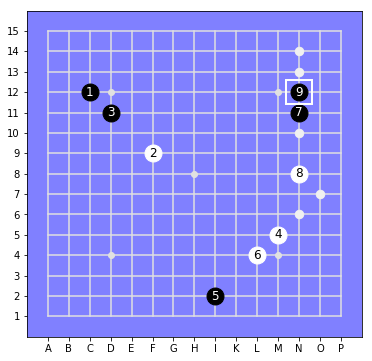

In [4]:
b = GomokuBoard(size=15, disp_width=6)
b.set(3,12).set(6,9).set(4,11)
b.set(12,5).set(9,2).set(11,4)
b.set(13,11).set(13,8).set(13,12)
b.display()
nh = b.getn9x9(2,13)
nh, b.heuristics.classify_nh(nh)

In [5]:
nh = b.getn9x9(13,13)
nh, b.heuristics.classify_nh(nh)

(|                 |
 |                 |
 |                 |
 |                 |
 |        *        |
 |        x        |
 |        x        |
 |                 |
 |                 |, [(4, 0, 6), (0, 0, 6)])

In [6]:
b.heuristics.f_range(nh.get_line('n'), c=0)

array([0, 0, 1, 1, 0, 0, 0, 0])

---
## Trading memory for speed

#### Recording stone impacts

Every stone creates an *impression* on its adjacent positions. The reach of every stone is 4 in each direction, so the influence of a stone can be expressed as a matrix of 9x9 32 bit integers representing the view on the stone from any of those 9x9 positions. This is what ```impact9x9``` is all about

In [7]:
import inspect
from FastGomokuBoard import FastGomokuBoard
b = FastGomokuBoard(size=15)
b.impact9x9

[[2147483648, 0, 0, 0, 8388608, 0, 0, 0, 32768],
 [0, 1073741824, 0, 0, 4194304, 0, 0, 16384, 0],
 [0, 0, 536870912, 0, 2097152, 0, 8192, 0, 0],
 [0, 0, 0, 268435456, 1048576, 4096, 0, 0, 0],
 [1, 2, 4, 8, 0, 16, 32, 64, 128],
 [0, 0, 0, 2048, 524288, 134217728, 0, 0, 0],
 [0, 0, 1024, 0, 262144, 0, 67108864, 0, 0],
 [0, 512, 0, 0, 131072, 0, 0, 33554432, 0],
 [256, 0, 0, 0, 65536, 0, 0, 0, 16777216]]

It's much easier to see what's going on, if we look at the base-2 logarithms. Then what we get is the position of the single bit that represents the relative position of the stone that is responsible for the *impression*.

In [8]:
np.log2(b.impact9x9)

/Users/wgiersche/workspace/tutorials/other_stuff/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


array([[ 31., -inf, -inf, -inf,  23., -inf, -inf, -inf,  15.],
       [-inf,  30., -inf, -inf,  22., -inf, -inf,  14., -inf],
       [-inf, -inf,  29., -inf,  21., -inf,  13., -inf, -inf],
       [-inf, -inf, -inf,  28.,  20.,  12., -inf, -inf, -inf],
       [  0.,   1.,   2.,   3., -inf,   4.,   5.,   6.,   7.],
       [-inf, -inf, -inf,  11.,  19.,  27., -inf, -inf, -inf],
       [-inf, -inf,  10., -inf,  18., -inf,  26., -inf, -inf],
       [-inf,   9., -inf, -inf,  17., -inf, -inf,  25., -inf],
       [  8., -inf, -inf, -inf,  16., -inf, -inf, -inf,  24.]])

The central integer 0 is the position of the stone. If you go two steps north-east from there, you'll land at matrix(!) position $(2,6)$ with $V=8192$. Let's derive the meaning of that number. Each of the four bytes of the number describes a particular direction from east counter-clock-wise to north-west. So we'll look at the 8 bits of the seconde byte ```l1```: 

In [9]:
def as_bits(byte):
    return [np.sign(byte & (1<<i)) for i in range(7, -1, -1)]

def as_bitarray(code):
    # l3 is the nw-line. point 2,2 on that line sees the stone at a distance of 2
    l=code
    l0=(l & 0xFF)               # east
    l1=(l & 0xFF00) >> 8        # north east
    l2=(l & 0xFF0000) >> 16     # north
    l3=(l & 0xFF000000) >> 24   # north west
    return {
        'e': as_bits(l0),
        'ne': as_bits(l1),
        'n': as_bits(l2),
        'nw': as_bits(l3)
    }

as_bitarray(b.impact9x9[2][6])

{'e': [0, 0, 0, 0, 0, 0, 0, 0],
 'ne': [0, 0, 1, 0, 0, 0, 0, 0],
 'n': [0, 0, 0, 0, 0, 0, 0, 0],
 'nw': [0, 0, 0, 0, 0, 0, 0, 0]}

This 'ne' bit array represents the following line on the board: Position $V$ *sees* our stone 2 steps in sw-west direction, which is exactly what we wanted to achieve.
```
. . . . . . . . 0  
. . . . . . . 0 . 
. . . . . . 0 . . 
. . . . . 0 . . . 
. . . . V . . . .
. . . 0 . . . . .
. . 1 . . . . . .
. 0 . . . . . . .
0 . . . . . . . .
```

Now, this is all about performance in this notebook. We trade memory for speed. So we pre-compute the impact for each possible position on the entire board and store it! Hence, for each position we can just lookup the impact of a stone should we put it there. And the good news is: The bit representation of the total impact of any number of stones can simply be computed by bitwise or-ing each single impact. 

You may realize that in the below implementation we trade even more memory for computational ease - memory's so cheap!

In [10]:
print(inspect.getsource(b.impact_from))

    def impact_from(self, r,c):
        """
        Construct a complete nxn impact representation of a stone at row=r, col=c
        """
        src=np.hstack([
            np.zeros((self.size+8,c),dtype=np.int),
            np.vstack([
                np.zeros((r,9), dtype=np.int32), 
                self.impact9x9, 
                np.zeros((self.size-1-r,9), dtype=np.int32)
            ]),
            np.zeros((self.size+8,self.size-1-c),dtype=np.int)
        ])
        return (src[4:-4].T[4:-4].T).copy()



Let's look at an example, now in board coordinates, i.e. 1-15 left to right, 1-15 bottom up. The stone at (8,8) viewed from 2 steps nw, which is (6,10) results in the following representation.

In [11]:
b1 = FastGomokuBoard(size=15, stones=[(8,8)])
as_bitarray(b1.getnh(6,10)[0])

{'e': [0, 0, 0, 0, 0, 0, 0, 0],
 'ne': [0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 0, 0, 0, 0, 0, 0, 0],
 'nw': [0, 0, 1, 0, 0, 0, 0, 0]}

```
0 . . . . . . . .  
. 0 . . . . . . . 
. . 0 . . . . . . 
. . . 0 . . . . . 
. . . . V . . . .
. . . . . 0 . . .
. . . . . . 1 . .
. . . . . . . 0 .
. . . . . . . . 0
```

```stones``` is an array of 15x15 = 225 complete boards having pre-computed impacts for each field once occupied. The *or-ed* overlay of $n$ of those boards will represent the board having the $n$ stones on it.

---
## Pre-computed lines scores
The LineScoreHelper's lookup method doesn't respect the board boundaries yet. That's why it isn't used in the FastGomokuBoard implementation.

Class ```LineScoresHelper``` pre-computes and stores the scores for all possible lines (there are only 496 distinct combinations, btw.)

In [43]:
from GomokuTools2 import Heuristics, LineScoresHelper
h = Heuristics()
lsh = LineScoresHelper(h)

In [44]:
print(lsh.as_bits(49), lsh.as_bits(130))
lsh.lookup_score((43, 130))

[0, 0, 1, 1, 0, 0, 0, 1] [1, 0, 0, 0, 0, 0, 1, 0]


((2, 2), 4)

In [45]:
for b in range(256):
    for w in range(256):
        line = [as_bits(b), as_bits(w)]
        score = lsh.lookup_score((b,w), 0)
        if score[0] != h.cscore(line, 0):
            raise AssertionError("scores for %s, %s don't match" % (b, w))
            
print("All 496 possible lines of eight stones yield the same score. Good.")
# That assertion does even extend to illegal lines with two stones on top of each other.

All 496 possible lines of eight stones yield the same score. Good.


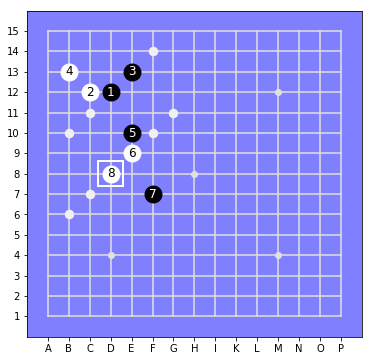

In [46]:
stones = [(4,12), (3,12), (5,13), (2,13), (5,10), (5,9),(6,7),(4,8)]
b0=FastGomokuBoard(size=15, disp_width=6, stones=stones)
b0.display(score='current')

In [47]:
nh = b0.getn9x9(4,11)
line = nh.get_line('nw')
nh, line

(|                 |
 |                 |
 |    o            |
 |      o x        |
 |        *        |
 |          x      |
 |                 |
 |        o        |
 |                 |, [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0]])

In [48]:
b0.lsh.lookup_score((16, 12), c=1)

((2, 1), 3)

In [52]:
Heuristics().cscore(line, c=1, edges=b0.all_edges(4,11)[3])

(0, 0)

In [53]:
b0.all_edges(4,11)[3]

(None, 7)